## Importanto as bibliotecas necessarias:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

## Configurando o dataset e os hiperparametros:

In [5]:
batch_size = 128
latent_dim = 20
lr = 0.0002
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cuda


## Definicao das redes neurais adversarias (GAN):

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

## Instanciando os objetos, otimizadores e funcao de perda:

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

beta_1 = 0.5 # parameters control the optimizer's momentum
beta_2 = 0.999 # parameters control the optimizer's momentum

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

criterion = nn.BCELoss()

## Treinamento:

[Epoch 10/200] [Avg D loss: 0.42396193321545916] [Avg G loss: 1.673785484155019]
[Epoch 20/200] [Avg D loss: 0.5853469554583232] [Avg G loss: 1.0897266651789348]
[Epoch 30/200] [Avg D loss: 0.6177046848932902] [Avg G loss: 0.9942712354660034]
[Epoch 40/200] [Avg D loss: 0.6230764662424724] [Avg G loss: 0.970415314356486]
[Epoch 50/200] [Avg D loss: 0.6265060960451762] [Avg G loss: 0.9544430751800537]
[Epoch 60/200] [Avg D loss: 0.627135934193929] [Avg G loss: 0.9532108990351359]
[Epoch 70/200] [Avg D loss: 0.6295145765940349] [Avg G loss: 0.9426573600769043]
[Epoch 80/200] [Avg D loss: 0.6297987906138102] [Avg G loss: 0.9359451483090718]
[Epoch 90/200] [Avg D loss: 0.6302341864903768] [Avg G loss: 0.9361674426396688]
[Epoch 100/200] [Avg D loss: 0.6281314740180969] [Avg G loss: 0.9392502423922221]
[Epoch 110/200] [Avg D loss: 0.6278823879559835] [Avg G loss: 0.9383439526557923]
[Epoch 120/200] [Avg D loss: 0.62937699619929] [Avg G loss: 0.933637254079183]
[Epoch 130/200] [Avg D loss: 0

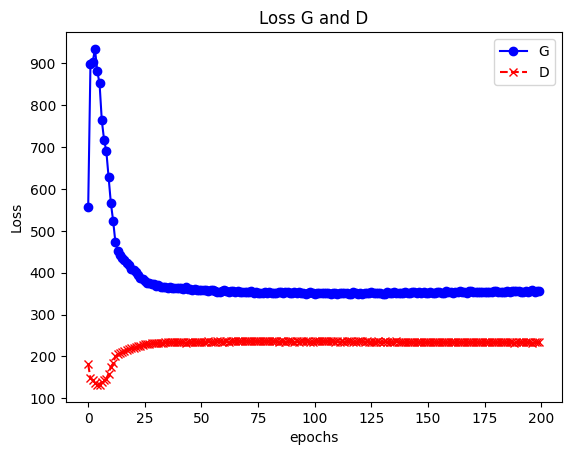

In [6]:
g_loss_per_epoch = []
d_loss_per_epoch = []

for epoch in range(epochs):
    d_loss_accumulated = 0.0
    g_loss_accumulated = 0.0

    for i, (imgs, _) in enumerate(train_loader):
        real = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        optimizer_D.zero_grad()
        real_imgs = imgs.to(device)
        pred_real = discriminator(real_imgs)
        loss_real = criterion(pred_real, real)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        pred_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(pred_fake, fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        d_loss_accumulated += d_loss.item()

        optimizer_G.zero_grad()
        pred_fake = discriminator(fake_imgs)
        g_loss = criterion(pred_fake, real)
        g_loss.backward()
        optimizer_G.step()

        g_loss_accumulated += g_loss.item()

        if i == len(train_loader) - 1 and (epoch + 1) % 10 == 0:
            d_loss_avg = d_loss_accumulated / len(train_loader)
            g_loss_avg = g_loss_accumulated / len(train_loader)
            print(f"[Epoch {epoch+1}/{epochs}] [Avg D loss: {d_loss_avg}] [Avg G loss: {g_loss_avg}]")

    torch.save(generator.state_dict(), f'./epochs_gan/g/g_epoch_{epoch + 1}.pth')
    torch.save(discriminator.state_dict(), f'./epochs_gan/d/d_epoch_{epoch + 1}.pth')

    g_loss_per_epoch.append(g_loss_accumulated)
    d_loss_per_epoch.append(d_loss_accumulated)

plt.title('Loss G and D')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(list(range(epochs)), g_loss_per_epoch, label='G', color='b', linestyle='-', marker='o')
plt.plot(list(range(epochs)), d_loss_per_epoch, label='D', color='r', linestyle='--', marker='x')
plt.legend()
plt.show()

## Gerando imagens:

/tmp/ipykernel_32022/3881444285.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_gan/g/g_epoch_200.pth'))


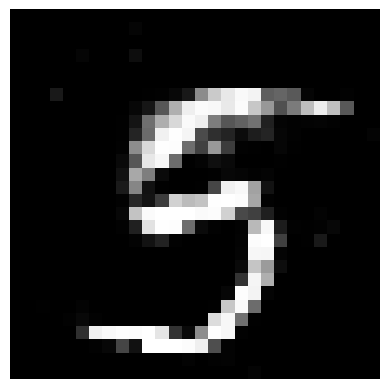

In [36]:
def generate_images(model, device):
    model.eval()
    model.load_state_dict(torch.load(f'./epochs_gan/g/g_epoch_200.pth'))
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        sample = generator(z).cpu()
        sample = sample.view(28, 28)

        return sample

sample = generate_images(generator, device)
plt.imshow(sample, cmap='gray')
plt.axis('off')
plt.show()